### Making MD Inputs
### Joe Laforet Jr.
#### jola3134@colorado.edu

This notebook serves as a self-contained utility for a user to prepare a protein-polymer system for simulation with an MD engine. We demonstrate export to both GROMACS and OpenMM. 

For simplicity, we assume the user has already generated the fragments of the polymer chains in the previous `building_random_co-polymers.ipynb` notebook. If you did NOT do this, or want to use a different set of monomers, please adjust your code accordingly.

Information is broken up to the following schema:
## Table of Contents
- 0.0 Logging/Imports
- 1.0 Load cached monomers
- 1.1 Clean the Protein
- 1.2 Pack the Protein with Polymers
- 1.3 Solvate the Protein-Polymer System
- 1.4 Export to Interchange
- 2.0 Export to MD whatever


---

#### 0.0 Logging/Imports

In [1]:
import logging
logging.basicConfig(level=logging.INFO, force=True)

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from polymerist.rdutils.rdkdraw import set_rdkdraw_size, disable_substruct_highlights, disable_kekulized_drawing

MOL_IMG_WIDTH  : int = 300
MOL_IMG_HEIGHT : int = 200
MOL_IMG_SIZE = (MOL_IMG_WIDTH, MOL_IMG_HEIGHT)

disable_kekulized_drawing()
disable_substruct_highlights()
set_rdkdraw_size(MOL_IMG_WIDTH, MOL_IMG_WIDTH / MOL_IMG_HEIGHT)

from pathlib import Path
from polymerist.genutils.fileutils.pathutils import assemble_path

OUTPUT_DIR = Path('Building_Demos') # dummy directory for writing without tampering with example inputs
OUTPUT_DIR.mkdir(exist_ok=True)

WORKING_DIR = OUTPUT_DIR / 'Fibronectin_MD_demo'
WORKING_DIR.mkdir(exist_ok=True)

project_name : str = 'Fibronectin_MD'

INFO:rdkit:Enabling RDKit 2023.09.6 jupyter extensions
INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


#### 1.0 Load cached monomers

In [2]:
# Load in fragment files from cache
from polymerist.polymers.monomers import MonomerGroup

#fragments_path = assemble_path(WORKING_DIR, project_name, postfix='fragments', extension='json')

fragments_path = Path('Building_Demos/ATRP_demo/ATRP_polymer_brush_fragments.json')

monogrp = MonomerGroup.from_file(fragments_path)

##### Let's take a look at what we're working with.

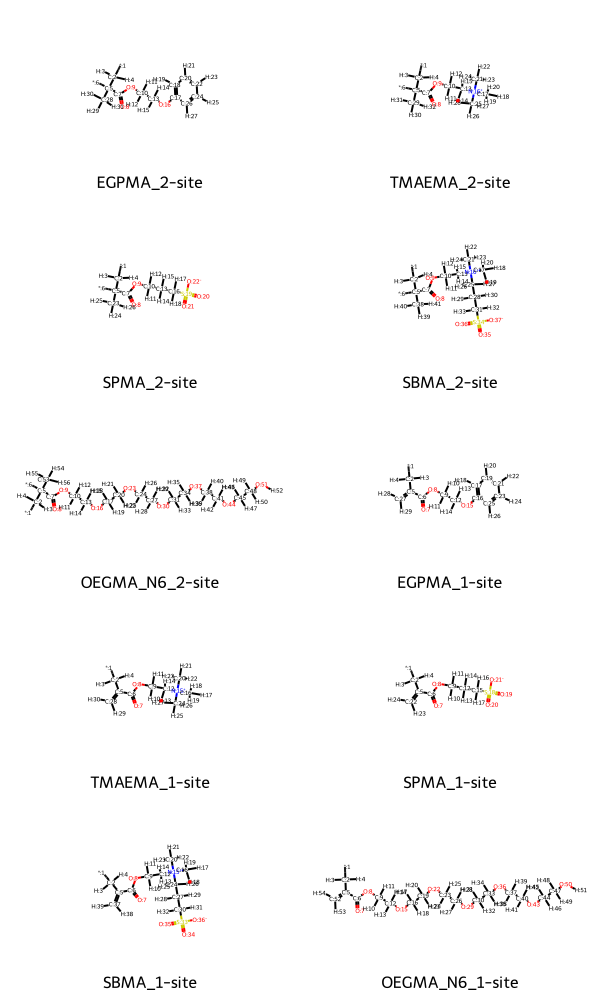

In [3]:
MolsToGridImage([mol for _, mol in monogrp.iter_rdmols()], molsPerRow=2, subImgSize=MOL_IMG_SIZE, legends=monogrp.monomers.keys())

#### 1.1 Clean the Protein

In [4]:
from openff.toolkit import Molecule, Topology
from polymerist.mdtools.openfftools.partition import partition


If we attempt to load in a PDB file, we are likely to encounter an error. OpenFF REQUIRES all protein data to be named according to the [`Chemical Component Dictionary`](https://www.wwpdb.org/data/ccd) standard. Not all PDB's are named this way, but luckily it is easy to fix this.

In [16]:
FN_path = 'Building_Demos/Fibronectin_MD_demo/1fnf_8to10_clean.pdb'

try:
    off_pro_top = Topology.from_pdb(FN_path)
except ValueError:
    print("FATAL ERROR!")
    print("Contents of PDB file are not named correctly!")
was_partitioned = partition(off_pro_top)
assert was_partitioned                         

FATAL ERROR!
Contents of PDB file are not named correctly!


In [17]:
from openmm.app import pdbfile
import pdbfixer
from pdbfixer import PDBFixer

pH = 7.0

fixer = PDBFixer(filename=FN_path)

fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()

fixer.addMissingHydrogens(pH)

pdbfile.PDBFile.writeFile(fixer.topology, 
                          fixer.positions, 
                          open('Building_Demos/Fibronectin_MD_demo/fixed_1fnf_8to10.pdb', 'w'))

off_pro_top = Topology.from_pdb('Building_Demos/Fibronectin_MD_demo/fixed_1fnf_8to10.pdb')
was_partitioned = partition(off_pro_top)
assert was_partitioned      

off_pro_top.visualize()

NGLWidget()

#### 1.2 Pack the Protein with Polymers

In [19]:
from openff.units import Quantity
from openmm.unit import nanometer, gram, centimeter
from polymerist.mdtools.openfftools import boxvectors

# Define box
box_padding: Quantity = 1.5 * nanometer  # Padding between protein and polymers
box_vecs_tight = boxvectors.get_topology_bbox(off_pro_top)
box_vecs = boxvectors.pad_box_vectors_uniform(box_vecs_tight, box_padding)

# Target density
target_density: Quantity = 1.0 * gram * centimeter**-3

In [40]:
seq_monomer_mapper = {
    'D': 'SBMA',
    'C': 'SPMA',
    'E': 'OEGMA',
    'A': 'EGPMA',
    'B': 'TMAEMA'
}

term_orient_mapper = {
    'D' : 'SBMA_1-site',
    'C' : 'SPMA_1-site',
    'E' : 'OEGMA_N6_1-site',
    'A' : 'EGPMA_1-site',
    'B' : 'TMAEMA_1-site'
}

# rename to 3-letter residue names in PDB file
resname_map={ 
        'SBMA_1-site'     : 'SB1',
        'SBMA_2-site'     : 'SB2',
        'SPMA_1-site'     : 'SP1',
        'SPMA_2-site'     : 'SP2',
        'OEGMA_N6_1-site' : 'OE1',
        'OEGMA_N6_2-site' : 'OE2',
        'EGPMA_1-site'    : 'EG1',
        'EGPMA_2-site'    : 'EG2',
        'TMAEMA_1-site'   : 'TM1',
        'TMAEMA_2-site'   : 'TM2'
    }

print(make_polymer_filename("ABCEDABCDE", seq_monomer_mapper))

EGPMA-TMAEMA-SPMA-SBMA-OEGMA_seq=ABCEDABCDE_10-mer_charged.sdf


In [28]:
print(make_polymer_filename("ACEDE", seq_monomer_mapper))

EGPMA-SPMA-SBMA-OEGMA_seq=ACEDE_5-mer_charged.sdf


In [29]:
print(make_polymer_filename("ECEDE", seq_monomer_mapper))

SPMA-SBMA-OEGMA_seq=ECEDE_5-mer_charged.sdf


In [82]:
import os
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from typing import Dict
from polymerist.polymers.building import build_linear_polymer, mbmol_to_openmm_pdb
from polymerist.polymers.building import mbmol_to_rdmol
from polymerist.rdutils.rdcoords.piercing import summarize_ring_piercing
from polymerist.mdtools.openfftools.topology import topology_from_sdf
from openff.toolkit import Topology as OFFTopology
from polymerist.mdtools.openfftools import topology
from polymerist.mdtools.openfftools.partialcharge.molchargers import NAGLCharger
from polymerist.mdtools.openfftools.topology import get_largest_offmol

def make_polymer_filename(seq: str, seq_monomer_mapper: dict, charged: bool = True) -> str:
    """
    Create a self-describing filename for a polymer fragment.

    Rules:
      - Monomer names in the prefix follow alphabetical order of the mapper keys
        (e.g. 'A', 'B', 'C', ...). Only symbols that appear in `seq` are included.
      - Filename format:
            <monomer-prefix>_<sequence>_<length>-mer[_charged].sdf
        Example:
            EGPMA-TMAEMA-SPMA-SBMA-OEGMA_N6_ABCEDE_6-mer_charged.sdf

    Parameters
    ----------
    seq:
        Polymer sequence string, e.g. "ABCEDE".
    seq_monomer_mapper:
        dict mapping single-char symbols to monomer names, e.g.
        {'D': 'SBMA', 'C': 'SPMA', 'E': 'OEGMA_N6', 'A': 'EGPMA', 'B': 'TMAEMA'}
    charged:
        If True, append "_charged" before the extension.

    Returns
    -------
    filename : str
        The generated filename.
    """
    seq = str(seq)  # ensure it's a string
    if not seq:
        raise ValueError("seq must be a non-empty string")

    # Validate all symbols in seq are present in the mapper
    missing = sorted({s for s in seq} - set(seq_monomer_mapper.keys()))
    if missing:
        raise KeyError(f"Sequence contains symbols not found in mapper: {missing}")

    # Determine ordered keys = alphabetical order of mapper keys,
    # then keep only those that appear in seq (preserves the A,B,C... order)
    ordered_keys = [k for k in sorted(seq_monomer_mapper.keys()) if k in seq]

    # Map to monomer names (deduplicated by symbol presence)
    monomers_used = [seq_monomer_mapper[k] for k in ordered_keys]

    # Join monomer names with hyphens
    monomer_prefix = "-".join(monomers_used) if monomers_used else "NO_MONOMERS"

    length = len(seq)
    filename = f"{monomer_prefix}_seq={seq}_{length}-mer"
    if charged:
        filename += "_charged"
    #filename += ".sdf"
    return filename


# === wrapper around your process_sequence ===
def process_sequence(args):
    """
    Your existing builder. Needs:
    (sequence, seq_monomer_mapper, term_orient_mapper, 
     resname_map, n_monomers, monogrp, WORKING_DIR)
    """
    sequence_whole, seq_monomer_mapper, term_orient_mapper, resname_map, n_monomers, monogrp, WORKING_DIR = args

    charged_polymer_name = make_polymer_filename(sequence_whole, seq_monomer_mapper, charged=True)
    uncharged_polymer_name = make_polymer_filename(sequence_whole, seq_monomer_mapper, charged=False)

    sdf_path = assemble_path(WORKING_DIR, uncharged_polymer_name, extension='sdf')
    sdf_path_charged = assemble_path(WORKING_DIR, charged_polymer_name, postfix='charged', extension='sdf')
    pdb_path = assemble_path(WORKING_DIR, uncharged_polymer_name, extension='pdb')

    if os.path.exists(sdf_path_charged):
        return f"Skipped {sequence_whole} (already exists)"

    # === copy in your build pipeline ===
    # NOTE: I'm not inlining all the chemistry code here for brevity,
    # but you'd paste your full builder steps here (build chain, PDB, SDF, charges).
    # At the end, write to `sdf_path_charged`.

    offtop = None
    
    try:
        print()
        print(f"Building {sequence_whole}")
        print()

        chain = None
        offtop = None
        
        # Step 1 & 2: Build Chain and Save PDB (only if PDB doesn't exist)
        if not os.path.exists(pdb_path):
            print(f"Creating PDB for {uncharged_polymer_name}")
            head_undiff, *sequence_middle, tail_undiff = sequence_whole # split into parts
            sequence_middle : str = ''.join(sequence_middle) # unpacking mid makes it a list at first

            monogrp_local = MonomerGroup(monomers=monogrp.monomers) # make copy to avoid cross-pollination
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }

            # 1. Build Chain, make sure no "ring piercing events happen"

            successful_build = False
            while not successful_build:
                chain = build_linear_polymer(
                        monomers=monogrp_local,
                        n_monomers=len(sequence_whole),
                        sequence=sequence_middle, # this will be better labelled
                        energy_minimize=True,
                        allow_partial_sequences=True, # doesn't matter here but, allow you to have numbers of middle monomers that aren't multiples of 3, in this case
                        )

                poly_mol = mbmol_to_rdmol(chain)
                pinprics_out = summarize_ring_piercing(poly_mol)

                if pinprics_out == {}:
                    successful_build = True
                    print("Build Success!")
                else:
                    print("PIERCING REDO")
                    print(pinprics_out)

            # 2. Save PDB
            mbmol_to_openmm_pdb(
                pdb_path,
                chain, 
                resname_map=resname_map)
            print(f"Created PDB: {pdb_path}")
        else:
            print(f"PDB already exists: {pdb_path}")

        # Steps 3, 4, 5: Create topology and save uncharged SDF (only if SDF doesn't exist)
        if not os.path.exists(sdf_path):
            print(f"Creating topology and uncharged SDF for {uncharged_polymer_name}")
            # Need to get monogrp again for topology creation
            head_undiff, *sequence_middle, tail_undiff = sequence_whole
            monogrp_local = MonomerGroup(monomers=monogrp.monomers)
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }
            
            # 3. OpenFF Topology & Partition
            offtop = OFFTopology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
            was_partitioned = partition(offtop)
            assert was_partitioned

            # 4. Fix residue names
            for mol in offtop.molecules:
                for atom in mol.atoms:
                    if 'residue_name' in atom.metadata:
                        atom.metadata['extended_name'] = atom.metadata['residue_name']
                        atom.metadata['residue_name'] = atom.metadata['residue_name'][:3]

            # 5. Save standard SDF
            topology.topology_to_sdf(sdf_path, offtop)
            print(f"Created uncharged SDF: {sdf_path}")
        else:
            print(f"Uncharged SDF already exists: {sdf_path}")

        # Steps 6 & 7: Charge molecule and save charged SDF (always do this if we got here)
        print(f"Creating charged SDF for {uncharged_polymer_name}")
        
        # If we didn't create the topology above, we need to create it now for charging
        if offtop is None:
            # Need to get monogrp again for topology creation
            head_undiff, *sequence_middle, tail_undiff = sequence_whole
            monogrp_local = MonomerGroup(monomers=monogrp.monomers)
            monogrp_local.term_orient = {
                        'head' : term_orient_mapper[head_undiff],
                        'tail' : term_orient_mapper[tail_undiff],
                        }
            
            offtop = OFFTopology.from_pdb(pdb_path, _custom_substructures=monogrp.monomers)
            was_partitioned = partition(offtop)
            assert was_partitioned

            # Fix residue names (in case we skipped the SDF creation step)
            for mol in offtop.molecules:
                for atom in mol.atoms:
                    if 'residue_name' in atom.metadata:
                        atom.metadata['extended_name'] = atom.metadata['residue_name']
                        atom.metadata['residue_name'] = atom.metadata['residue_name'][:3]

        # 6. Assign Partial Charges
        offmol = topology.get_largest_offmol(offtop)
        charger = NAGLCharger()
        charged_mol = charger.charge_molecule(offmol)
        charged_top = charged_mol.to_topology()

        # 7. Save charged SDF
        topology.topology_to_sdf(sdf_path_charged, charged_top)
        print(f"Wrote charged structure to {sdf_path_charged}")
        
        return f"Successfully processed {uncharged_polymer_name}"

    except Exception as e:
        error_msg = f"Warning: Failed to process {uncharged_polymer_name}: {e}"
        print(error_msg)
        return error_msg


    return f"Successfully built {sequence_whole}"


# === main loader function ===
def load_or_generate_polymers(
    sequence_counts: Dict[str, int],
    seq_monomer_mapper: dict,
    term_orient_mapper: dict,
    resname_map: dict,
    molecule_directory: str,
    monogrp,
    charged: bool = True,
) -> Dict[str, "openff.toolkit.topology.Molecule"]:
    """
    Load polymers from cache, and generate them in parallel if missing.

    Parameters
    ----------
    sequence_counts : dict
        Dict of {sequence: count} for unique sequences to load.
    seq_monomer_mapper : dict
        Mapping from sequence symbols to monomer names.
    term_orient_mapper : dict
        Mapping from sequence symbols to terminal monomer names.
    resname_map: dict
        Mapping from monomer name to 3-character code for PDB
    molecule_directory : str
        Path to cache directory for molecules.
    monogrp : MonomerGroup
        MonomerGroup object used for building.
    charged : bool
        Whether to build/load charged SDFs.

    Returns
    -------
    loaded_mols : dict
        Mapping {sequence: off_mol_object}.
    """

    missing_sequences = []
    loaded_mols = {}

    molecule_directory.mkdir(exist_ok=True)

    # Try to load from cache
    for sequence in sequence_counts:
        filename = make_polymer_filename(sequence, seq_monomer_mapper, charged=charged)
        filepath = os.path.join(molecule_directory, filename)
        if not os.path.exists(filepath):
            missing_sequences.append(sequence)
            continue

        off_poly_top = topology_from_sdf(filepath)
        off_poly_mol = get_largest_offmol(off_poly_top)
        loaded_mols[sequence] = off_poly_mol

    # Build missing in parallel
    if missing_sequences:
        args_list = [
            (seq, seq_monomer_mapper, term_orient_mapper, resname_map, len(seq), monogrp, molecule_directory)
            for seq in missing_sequences
        ]

        num_cores = max(1, mp.cpu_count() // 2)
        print(f"Generating {len(missing_sequences)} polymers using {num_cores} cores...")

        with Pool(processes=num_cores) as pool:
            results = list(tqdm(
                pool.imap(process_sequence, args_list),
                total=len(args_list),
                desc="Building missing polymers"
            ))

        # Make sure all workers are done
        pool.close()
        pool.join()
        
        for msg in results:
            print(msg)

        # Reload the missing ones
        for seq in missing_sequences:
            filename = make_polymer_filename(seq, seq_monomer_mapper, charged=False)
            filename = filename + ".sdf"
            filepath = os.path.join(molecule_directory, filename)
            off_poly_top = topology_from_sdf(filepath)
            off_poly_mol = get_largest_offmol(off_poly_top)
            loaded_mols[seq] = off_poly_mol

    return loaded_mols


In [88]:
# draw probabilities according to experiment
# 3:3:2 + 5% SBMA, SPMA, OEGMA, EGPMA, TMAEMA

import numpy as np
from collections import Counter

probas = [0.3583, 0.3583, 0.2334, 0.05,  0.0]
chars  = [    'D',   'C',    'E',  'A',  'B']

# Step 1: Randomly generate N polymer sequences
def generate_random_polymer(N, characters, probabilities):
    return ''.join(np.random.choice(characters, size=N, p=probabilities))

polymer_sequences = [generate_random_polymer(10, chars, probas) for _ in range(63)]

# Define a canonical form: min of the string and its reverse
def canonical(s):
    return min(s, s[::-1])

# Convert all strings to their canonical form
canonical_polys = [canonical(p) for p in polymer_sequences]

# Step 2: Count how many times each unique polymer was generated
sequence_counts = Counter(canonical_polys)
print(sequence_counts)

Counter({'DCCDDCCEDD': 1, 'CDCECECDCE': 1, 'CCEACCACDC': 1, 'CCCCDCDCEE': 1, 'CDECDCEDDE': 1, 'DDCCACEDEE': 1, 'CDCDEDCDDC': 1, 'DCCEECDCDE': 1, 'DDDDDDCEEE': 1, 'ADCEDDDEDA': 1, 'CEECDCCDDD': 1, 'DCDEEEDEDE': 1, 'CDCEECDCED': 1, 'CDDCEDEACE': 1, 'DCDCECDDCD': 1, 'DDDADEADCE': 1, 'DCCCCCDDDD': 1, 'CEECECEDDD': 1, 'CADCCCCDCE': 1, 'DCDCCCCDED': 1, 'ADCCDDDECE': 1, 'CCECECCEDD': 1, 'DDCCCEDDDD': 1, 'CCECDDCCDC': 1, 'CCEEDEDDAE': 1, 'CADCECCDED': 1, 'EDDCDAECEE': 1, 'CDCEEEEDCD': 1, 'CEDDDECEDD': 1, 'ACCECECEED': 1, 'CCEDDECDDE': 1, 'CCCDCCECCD': 1, 'CDDEEDEEED': 1, 'CDCCDDECDC': 1, 'CEDCCACDDD': 1, 'CCDEDCDAEC': 1, 'CDCCCCDCDC': 1, 'CEADECCEEC': 1, 'EDCCCDEEDE': 1, 'ACCCCCDEDE': 1, 'DCEEECCCEE': 1, 'ACDCEADCDD': 1, 'CCCCCDACEC': 1, 'ACCEDDCDDE': 1, 'DECEDCECCE': 1, 'CCCCCDDDCC': 1, 'CDDCDCCDCD': 1, 'ECDDDAEDCE': 1, 'CCEEDADEAE': 1, 'CEDDECDDEE': 1, 'DCDDDDDDDD': 1, 'CCDCECDCEC': 1, 'EDAEACDEDE': 1, 'CCCDECECEC': 1, 'DDCCDCDCED': 1, 'CCECADCDDC': 1, 'DCACDCEACE': 1, 'DDDDCDDECE': 1, 'ADAD

In [ ]:
loaded_mols = load_or_generate_polymers(sequence_counts, seq_monomer_mapper, term_orient_mapper,
                                        resname_map, WORKING_DIR/'Cached_Molecules',
                                        monogrp)
    

In [91]:
len(loaded_mols)

63

In [ ]:
def pack_topology_with_random_polymers_from_sequences(offtop,
                                                       characters: List[str],
                                                       probabilities: List[float],
                                                       box_vecs,
                                                       N: int,
                                                       molecule_directory: str,
                                                       exclusion: Optional = None,
                                                       working_directory=None,
                                                       retain_working_files=True,
                                                       polymer_length: int = 5,
                                                       polymer_type_prefix: str = "SBMA-EGPMA"):
    '''
    Pack a Topology with N randomly generated polymer sequences, selecting matching .sdf files.

    Parameters:
    - offtop: Topology to solvate.
    - characters: Possible monomer units ("A", "B", etc).
    - probabilities: Probabilities associated with each monomer unit.
    - box_vecs: Desired box vectors.
    - N: Total number of polymer chains to insert.
    - molecule_directory: Directory where .sdf files are stored.
    - polymer_length: Number of monomers per chain (default 5).
    - polymer_type_prefix: Prefix for molecule filenames (e.g., "SBMA-EGPMA").
    '''
    

    assert abs(sum(probabilities) - 1.0) < 1e-8, "Probabilities must sum to 1."
    assert len(characters) == len(probabilities), "Characters and probabilities must match."

    box_vecs = boxvectors.box_vectors_flexible(box_vecs)
    min_box_vecs = boxvectors.get_topology_bbox(offtop) * 1.1
    if exclusion is not None:
        min_box_vecs = boxvectors.pad_box_vectors_uniform(min_box_vecs, exclusion)

    if not np.all(box_vecs >= min_box_vecs):
        raise boxvectors.BoxVectorError(f'Desired box dimensions ({box_vecs}) are smaller than minimum excluded Topology dimensions ({min_box_vecs})')

    box_vol = boxvectors.get_box_volume(box_vecs, units_as_openm=True)

    # Step 1: Randomly generate N polymer sequences
    def generate_random_polymer(N, characters, probabilities):
        return ''.join(np.random.choice(characters, size=N, p=probabilities))

    polymer_sequences = [generate_random_polymer(polymer_length, characters, probabilities) for _ in range(N)]

    # Define a canonical form: min of the string and its reverse
    def canonical(s):
        return min(s, s[::-1])

    # Convert all strings to their canonical form
    canonical_polys = [canonical(p) for p in polymer_sequences]

    # Step 2: Count how many times each unique polymer was generated
    sequence_counts = Counter(canonical_polys)
    print(sequence_counts)

    # Step 3: Load molecule objects matching each unique sequence
    loaded_mols = {}
    for sequence in sequence_counts:
        filename = f"{polymer_type_prefix}_{sequence}_{polymer_length}-mer_charged.sdf"
        filepath = os.path.join(molecule_directory, filename)
        if not os.path.exists(filepath):
            raise FileNotFoundError(f"Could not find file for sequence {sequence}: {filepath}")
        off_poly_top = topology_from_sdf(filepath)
        off_poly_mol = get_largest_offmol(off_poly_top)
        loaded_mols[sequence] = off_poly_mol

    # Step 4: Prepare lists for packmol
    solvent_list = []
    num_list = []
    seq_list = []

    for sequence, count in sequence_counts.items():
        solvent_list.append(loaded_mols[sequence])
        num_list.append(count)
        seq_list.append(sequence)

    # Step 5: Pack the box
    LOGGER.info(f"Packing {sum(num_list)} total polymers: {sequence_counts}")
    packed_top = packmol.pack_box(
        solvent_list,
        num_list,
        offtop,
        box_vectors=box_vecs,
        box_shape=packmol.UNIT_CUBE,
        center_solute='BRICK',
        working_directory=working_directory,
        retain_working_files=retain_working_files
    )
    LOGGER.info('Packmol packing converged')

    packed_top.box_vectors = box_vecs
    print("Sequences generated:")
    print(seq_list)
    return packed_top, solvent_list